In [8]:
pip uninstall MARS --y 

Found existing installation: MARS 1.0.0
Uninstalling MARS-1.0.0:
  Successfully uninstalled MARS-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install git+https://github.com/bianchimario/MARS

  Cloning https://github.com/bianchimario/MARS to /private/var/folders/kj/2bfwcpp56ljb52n904gv1_700000gn/T/pip-req-build-d587spjm
  Running command git clone --filter=blob:none --quiet https://github.com/bianchimario/MARS /private/var/folders/kj/2bfwcpp56ljb52n904gv1_700000gn/T/pip-req-build-d587spjm
  Resolved https://github.com/bianchimario/MARS to commit 7b74755f03a9d07f2da70a375781d295f103af5a
  Preparing metadata (setup.py) ... done
  Created wheel for MARS: filename=MARS-1.0.0-py3-none-any.whl size=14830 sha256=d8c21f3bf26b9d610e32e8c7795fffe8a05e9bb0002f76466a6fc083abd0675f
  Stored in directory: /private/var/folders/kj/2bfwcpp56ljb52n904gv1_700000gn/T/pip-ephem-wheel-cache-z3lt2nmn/wheels/7c/54/7a/9a1b3a604937feb86544be13c30bf12c1ee3b43b898c4a6af9
Successfully built MARS
Note: you may need to restart the kernel to use updated packages.


In [13]:
from downtime import load_dataset
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import classification_report
from MARS import *
import numpy as np
import random

# Getting the data

In [2]:
d = load_dataset("SelfRegulationSCP1")

X_train = d.X_train
X_test = d.X_test
y_train = d.y_train
y_test = d.y_test

In [4]:
print(d)

X_train: (268, 6, 896)
X_test: (293, 6, 896)
y_train: (268,)
y_test: (293,)
Metadata:
{'labels': {'0': 'negativity', '1': 'positivity'},
 'name': 'SelfRegulationSCP1',
 'task': 'classification'}


In [20]:
X_train

<Array [[[23, 21.7, ..., 21.5], ...], ...] type='268 * var * var * float64'>

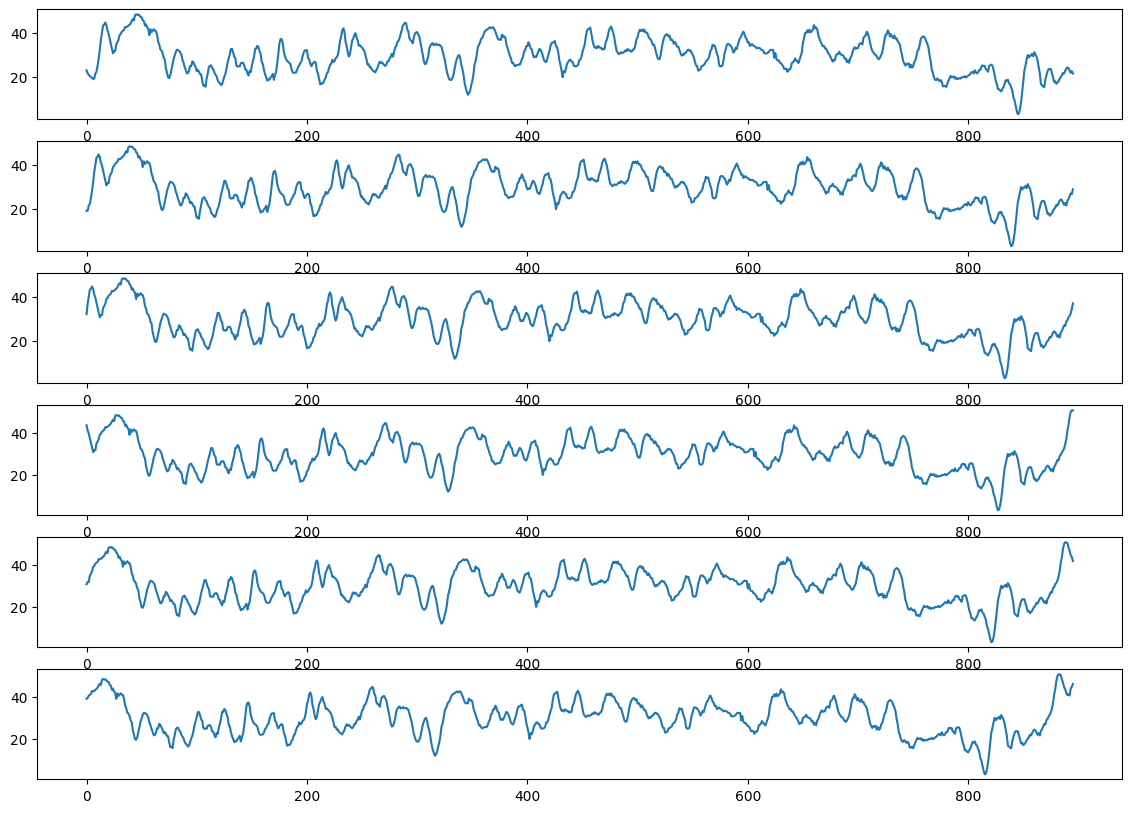

In [4]:
plt.figure(figsize=(14,10))

for i,dim in enumerate(d.X_train[0]):
    plt.subplot(6,1,i+1)
    plt.plot(dim)

# Multivariate Asynchronous Random Shapelets

In [3]:
shapelets = get_random_shapelets(X_train, num_shapelets=10, max_len=50, min_len=50, async_shapelets=False, seed=42)

In [4]:
shapelets[0]

[<Array [5.12, 3.25, 3.47, 2.91, ..., 22.2, 22.5, 23.1] type='50 * float64'>,
 <Array [5.5, 7.66, 9.03, 9.44, ..., 18.8, 16.4, 14.3, 13.2] type='50 * float64'>,
 <Array [11.2, 11.1, 11.2, 10, ..., 14.8, 16.3, 16.1, 17.4] type='50 * float64'>,
 <Array [7.66, 7.62, 8.28, 8.78, ..., 17.1, 16, 15.2, 14.1] type='50 * float64'>,
 <Array [5.81, 4.81, 1.84, 1.62, ..., 2.94, -0.38, -1.28] type='50 * float64'>,
 <Array [0.31, 1.06, 1.34, 2.31, ..., -1.91, -1.84, 0.34] type='50 * float64'>]

In [5]:
print('Num. shapelets = ', len(shapelets))
print('Num. dimensions = ', len(shapelets[0]))

Num. shapelets =  10
Num. dimensions =  6


In [12]:
dist = get_distance_sync(X_train[0], 6, shapelets[9])

dist

96.45362253435584

In [ ]:
def get_distance_fast(multivariate_time_series, shapelet):
    '''
    It does not work for asynchronous shapelets
    '''
    shapelet_length = len(shapelet[0])
    max_idx = len(multivariate_time_series[0]) - shapelet_length
    min_dist = float('inf')
    dimensions = len(shapelet)

    flat_shapelet = np.ravel(shapelet) # flattening array
    for idx in range(0, max_idx):
        subsequence = np.ravel([multivariate_time_series[dim][idx:idx+shapelet_length] for dim in range(0,dimensions)])
        flat_subsequence = np.ravel(subsequence) # flattening array
        #dist = distance.euclidean(flat_subsequence, flat_shapelet)
        dist = np.linalg.norm(flat_subsequence - flat_shapelet)
        if dist < min_dist:
            min_dist = dist

    return min_dist

In [7]:
# Transforming training set (getting distances from shapelets)
X_train_transformed = get_multivariate_distances(X_train, shapelets)

Calculating distances for TS # 0
Calculating distances for TS # 1
Calculating distances for TS # 2
Calculating distances for TS # 3
Calculating distances for TS # 4
Calculating distances for TS # 5
Calculating distances for TS # 6
Calculating distances for TS # 7
Calculating distances for TS # 8
Calculating distances for TS # 9
Calculating distances for TS # 10
Calculating distances for TS # 11
Calculating distances for TS # 12
Calculating distances for TS # 13
Calculating distances for TS # 14
Calculating distances for TS # 15
Calculating distances for TS # 16
Calculating distances for TS # 17
Calculating distances for TS # 18
Calculating distances for TS # 19
Calculating distances for TS # 20
Calculating distances for TS # 21
Calculating distances for TS # 22
Calculating distances for TS # 23
Calculating distances for TS # 24
Calculating distances for TS # 25
Calculating distances for TS # 26
Calculating distances for TS # 27
Calculating distances for TS # 28
Calculating distances fo

In [8]:
print(len(X_train_transformed))
print(len(X_train_transformed[0]))


268
20


In [4]:
X_test_transformed = get_multivariate_distances(X_test, shapelets)

/Users/mario/opt/anaconda3/envs/generali2023/lib/python3.10/site-packages/MARS/MARS.py:128: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_multivariate_distances" failed type inference due to: Invalid use of type(CPUDispatcher(<function get_distance_sync at 0x7fad53646e60>)) with parameters (ak.ArrayView(ak.ListArrayType(array(int64, 1d, C), ak.NumpyArrayType(array(float64, 1d, C), {}), {}), None, ()), int64, reflected list(ak.ArrayView(ak.NumpyArrayType(array(float64, 1d, C), {}), None, ()))<iv=None>)

During: resolving callee type: type(CPUDispatcher(<function get_distance_sync at 0x7fad53646e60>))
During: typing of call at /Users/mario/opt/anaconda3/envs/generali2023/lib/python3.10/site-packages/MARS/MARS.py (137)


File "../../../../opt/anaconda3/envs/generali2023/lib/python3.10/site-packages/MARS/MARS.py", line 137:
def get_multivariate_distances(time_series_dataset, shapelets):
    <source elided>
        for shapelet in s

Calculating distances for TS # 0


/Users/mario/opt/anaconda3/envs/generali2023/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "get_distance_sync" was compiled in object mode without forceobj=True.

File "../../../../opt/anaconda3/envs/generali2023/lib/python3.10/site-packages/MARS/MARS.py", line 117:
def get_distance_sync(multivariate_time_series, dimensions, shapelet):
    <source elided>
    flat_shapelet = np.ravel(shapelet) # flattening array
    for idx in range(0, max_idx):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/mario/opt/anaconda3/envs/generali2023/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is deprecated behaviour that will be removed in Numba 0.59.0.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-us

Calculating distances for TS # 1
Calculating distances for TS # 2
Calculating distances for TS # 3
Calculating distances for TS # 4
Calculating distances for TS # 5
Calculating distances for TS # 6
Calculating distances for TS # 7
Calculating distances for TS # 8
Calculating distances for TS # 9
Calculating distances for TS # 10
Calculating distances for TS # 11
Calculating distances for TS # 12
Calculating distances for TS # 13
Calculating distances for TS # 14
Calculating distances for TS # 15
Calculating distances for TS # 16
Calculating distances for TS # 17
Calculating distances for TS # 18
Calculating distances for TS # 19
Calculating distances for TS # 20
Calculating distances for TS # 21
Calculating distances for TS # 22
Calculating distances for TS # 23
Calculating distances for TS # 24
Calculating distances for TS # 25
Calculating distances for TS # 26
Calculating distances for TS # 27
Calculating distances for TS # 28
Calculating distances for TS # 29
Calculating distances f

# Classification

In [9]:
clf = lgb.LGBMClassifier()
clf.fit(X_train_transformed, y_train)

LGBMClassifier()

## Training set

In [76]:
y_pred_train = clf.predict(X_train_transformed)

In [77]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      1.00      1.00       133

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



## Test set

In [10]:
y_pred_test = clf.predict(X_test_transformed)

In [11]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       147
           1       0.65      0.89      0.75       146

    accuracy                           0.71       293
   macro avg       0.74      0.71      0.70       293
weighted avg       0.74      0.71      0.70       293

